In [126]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

import exoplanet as xo
import specgp as sgp

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

In [139]:
with pm.Model() as model:
    trace = pm.load_trace('traces/trace3')
    mu, sig = {}, {}
    for k, v in trace[0].items():
        vals = trace.get_values(k)
        mu[k] = np.mean(vals, axis=0)
        sig[k] = np.std(vals, axis=0)
        
ppm = np.array([20, 20, 20])
mu['logsig'] = np.log(ppm * 1e-3)

In [140]:
term1 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][0], 
                            log_w0=mu["logw"][0], 
                            log_Q=-np.log(np.sqrt(2))
                            )
term2 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][1], 
                            log_w0=mu["logw"][1], 
                            log_Q=mu["logQ"]
                            )
alpha1 = np.exp([0, mu["alpha1"][0], mu["alpha2"][0]])
alpha2 = np.exp([0, mu["alpha1"][1], mu["alpha2"][1]])
kernel = (sgp.terms.KronTerm(term1, alpha=alpha1) + 
          sgp.terms.KronTerm(term2, alpha=alpha2))

t = np.linspace(-1, 1, 1000)
logsig = np.array(mu["logsig"])
diag = np.exp(2*logsig)[:, None] * np.ones((3, len(t)))
mean = mu["mean"][:, None] * np.ones_like(t)
gp3 = xo.gp.GP(x=t, kernel=kernel, diag=diag, mean=sgp.means.KronMean(mean), J=4)

In [141]:
import bic 

r_ratio = np.linspace(0.001, 0.01, 30)
with pm.Model() as model:
    
    delta_bic3 = np.zeros(30)
    for i, r in enumerate(r_ratio):
        orbit = xo.orbits.KeplerianOrbit(period=5.0)
        mean = (xo.LimbDarkLightCurve([0.2, 0.3])
          .get_light_curve(orbit=orbit, r=r, t=t, texp=0.02)*1e3).T[0]
        mean = tt.ones(3)[:, None] * mean
        delta_bic3[i] = xo.eval_in_model(bic.delta_bic(gp3, mean, 4, t), mu)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [142]:
with pm.Model() as model:
    trace = pm.load_trace('traces/trace1')
    mu, sig = {}, {}
    for k, v in trace[0].items():
        vals = trace.get_values(k)
        mu[k] = np.mean(vals, axis=0)
        sig[k] = np.std(vals, axis=0)
        
mu['logsig'] = np.log(np.sum((ppm * 1e-3) ** 2) / 3) / 2

In [143]:
term1 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][0], 
                            log_w0=mu["logw"][0], 
                            log_Q=-np.log(np.sqrt(2))
                            )
term2 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][1], 
                            log_w0=mu["logw"][1], 
                            log_Q=mu["logQ"]
                            )

kernel = term1 + term2

t = np.linspace(-1, 1, 1000)
logsig = mu["logsig"] * tt.ones(len(t))
diag = np.exp(2*logsig)
mean = mu["mean"]
gp1 = xo.gp.GP(x=t, kernel=kernel, diag=diag, mean=mean, J=4)

In [144]:
import bic 

r_ratio = np.linspace(0.001, 0.01, 30)
with pm.Model() as model:
    
    delta_bic1 = np.zeros(30)
    for i, r in enumerate(r_ratio):
        orbit = xo.orbits.KeplerianOrbit(period=5.0)
        mean = (xo.LimbDarkLightCurve([0.2, 0.3])
          .get_light_curve(orbit=orbit, r=r, t=t, texp=0.02)*1e3).T[0]
        x = tt.as_tensor_variable(t)
        delta_bic1[i] = xo.eval_in_model(bic.delta_bic(gp1, mean, 4, x), mu)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Text(0.5, 1.0, 'Transit detection with solar\n noise observed by SOHO\n')

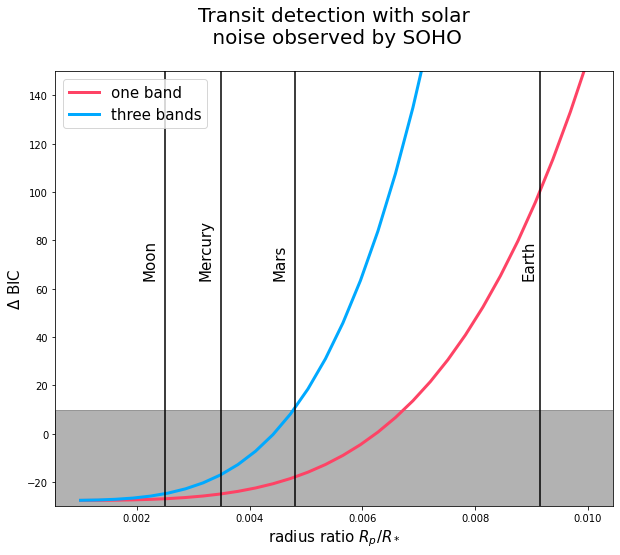

In [145]:
pl.figure(figsize=(10, 8))
pl.plot(r_ratio, delta_bic1, color=colors[0], linewidth=3, label="one band")
pl.plot(r_ratio, delta_bic3, color=colors[2], linewidth=3, label="three bands")
pl.axhspan(-30, 10, color='k', alpha=0.3)
pl.ylim(-30, 150)
pl.xlabel(r"radius ratio $R_p/R_*$", fontsize=15)
pl.ylabel(r"$\Delta\ \mathrm{BIC}$", fontsize=15)
pl.axvline(0.00915, color='k')
pl.axvline(0.0048, color='k')
pl.axvline(0.0035, color='k')
pl.axvline(0.0025, color='k')

annotation_kwargs = {
    "xycoords": 'figure fraction',
    "rotation": 90,
    "fontsize": 15
}
pl.annotate("Moon", xy=(0.23, 0.5), **annotation_kwargs)
pl.annotate("Mercury", xy=(0.32, 0.5), **annotation_kwargs)
pl.annotate("Mars", xy=(0.44, 0.5), **annotation_kwargs)
pl.annotate("Earth", xy=(0.84, 0.5), **annotation_kwargs)
pl.legend(fontsize=15)
pl.title("Transit detection with solar\n noise observed by SOHO\n", fontsize=20)

In [137]:
y = gp3.dot_l(np.random.randn(3*len(t), 1)).eval()
orbit = xo.orbits.KeplerianOrbit(period=5.0)
mean = (xo.LimbDarkLightCurve([0.2, 0.3])
          .get_light_curve(orbit=orbit, r=0.004, t=t, texp=0.02)*1e3).eval()

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


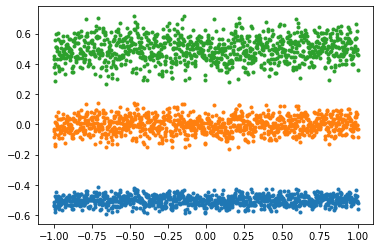

In [138]:
pl.plot(t, y[::3]+mean-0.5, '.')
pl.plot(t, y[1::3]+mean, '.')
pl.plot(t, y[2::3]+mean+0.5, '.')

array([[ 0.00822053],
       [-0.00245191],
       [ 0.00179111],
       ...,
       [-0.02742046],
       [-0.04086962],
       [-0.06999552]])